In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import re

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext slurm_magic
#useful for Notebook submission to HPC, not required

### Steps to process initial mapped BAM to bedgraph

To process the mapped reads, one would need to download the fastq from NCBI as indicated on the landing page, map the reads to the Williams82 reference + GFP (provided in /data), and run the following on the .bam output. 

In [ ]:
%%bash
# There is no bam mapping file for NPXZN:Luc-ET_1, it was not returned by JGI
# this subsets the bam files from whole genome to just region of interest

DIR=/homes/decook/data/jgiSoy/smRNA_Analysis/Alignments/

for i in ${DIR}*.bam; do
    samtools index ${i}
    OUT=${i%.bam}_eGFP.bam
    samtools view -b -h ${i} "EGFP" > ${OUT};
done

From the reads mapped only to the EGFP transcript from above, the below will summarize read coverage and output formated counts as:
    - Transcript
    - Start
    - Stop
    - Current base
    - Current base read count
    - Sample ID

In [ ]:
%%bash

module load HTSlib

DIR=~/data/jgiSoy/smRNA_Analysis/
cd ~/data/jgiSoy/smRNA_Analysis/Alignments/

for i in *_eGFP.bam; do
    OUT=${i%.bam}.bedtool.cov.txt
    SAMPLE=${i%_eGFP.bam}
    bedtools coverage -a ${DIR}eGFP.bed -b ${i} -d | \
    awk -v awkvar="$SAMPLE" 'BEGIN{OFS="\t";} {print $0, awkvar}' - > \
    ${OUT};
done

### Analysis of per nucleotide read depth files in /data

In [3]:
RunInfo_key = "~/data/jgiSoy/SMRTsilencing/data/sRNA_LIBRARIES_headless.txt"

def load_SRAdata(SRA_RunInfo):
    return pd.read_csv(SRA_RunInfo, sep="\t", header=0, index_col=False)

SeqRun_sRNA_info = load_SRAdata(RunInfo_key)
Dict_sRNALib2Name = SeqRun_sRNA_info.set_index('1=libraryName')['5=sampleName'].to_dict()

In [4]:
InDir='/homes/decook/data/jgiSoy/smRNA_Analysis/Alignments/' 
src_files = [f for f in os.listdir(InDir) if re.match('(.)+(.bedtool.cov.txt)\Z', f)]

sub_df = [pd.read_csv(InDir+q, sep="\t", header=None, index_col=False,
                      names=["target","e_start", "e_end", "position", "sRNA_count", "library"],
                      dtype={"sRNA_count" : "int64"}) for q in src_files]

sRNA_map = pd.concat(sub_df) 
sRNA_map['sample'] = sRNA_map['library'].map(Dict_sRNALib2Name)
sRNA_map['sample'] =sRNA_map['sample'].map(lambda x:x.lstrip("'").rstrip("'"))

In [5]:
# correctly mapped reads per library, generated with:
#  samtools view -c -F 260 ${IN_BAM}
Dict_total_sRNA= {'Luc-ET_2': 4790542,'Luc-ET_3': 8406123,
                  'eGFP.m3g3.v2_6': 3573878,'eGFP.m3g3_8': 3533953,'eGFP.m3g3_9': 3280696,
                  'eGFP.aseGFPv2_3': 835171,'eGFP.asGFP.v2_4': 2369055,'eGFP.aseGFP.v2_5': 918603,
                  'Egfp m6g1-2.v2_8': 793061,'Egfp m6g1-2.v2_9': 4160432,'Egfp m6g1-2_10': 4391922}

In [7]:
sRNA_map['lib_total'] = sRNA_map["sample"].map(Dict_total_sRNA)
sRNA_map['CPM'] = (sRNA_map["sRNA_count"] / sRNA_map["sample"].map(Dict_total_sRNA))* 1000000
sRNA_map.reset_index(inplace=True)
sRNA_map

,index,target,e_start,e_end,position,sRNA_count,library,sample,lib_total,CPM
0,0,EGFP,1,720,1,0,NPXZP,eGFP.m3g3_8,3533953,0.000000
1,1,EGFP,1,720,2,0,NPXZP,eGFP.m3g3_8,3533953,0.000000
2,2,EGFP,1,720,3,0,NPXZP,eGFP.m3g3_8,3533953,0.000000
3,3,EGFP,1,720,4,0,NPXZP,eGFP.m3g3_8,3533953,0.000000
4,4,EGFP,1,720,5,0,NPXZP,eGFP.m3g3_8,3533953,0.000000
...,...,...,...,...,...,...,...,...,...,...
7904,714,EGFP,1,720,715,1,NPXZO,Luc-ET_2,4790542,0.208745
7905,715,EGFP,1,720,716,1,NPXZO,Luc-ET_2,4790542,0.208745
7906,716,EGFP,1,720,717,1,NPXZO,Luc-ET_2,4790542,0.208745
7907,717,EGFP,1,720,718,0,NPXZO,Luc-ET_2,4790542,0.000000


### Vizualizing mapped reads

### Figure 7d 

[(0.0, 2000.0)]

Text(0.5, 1.0, 'sRNA mapping m3g3')

Text(0.5, 0, '')

Text(0, 0.5, 'sRNA CPM')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'sRNA mapping m6g1')

Text(0.5, 0, '')

Text(0, 0.5, ' ')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'sRNA mapping antisense')

Text(0, 0.5, 'sRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 100.0)]

Text(0.5, 1.0, 'sRNA mapping LUC-NT')

Text(0.5, 0, 'GFP mRNA bp')

Text(0, 0.5, ' ')

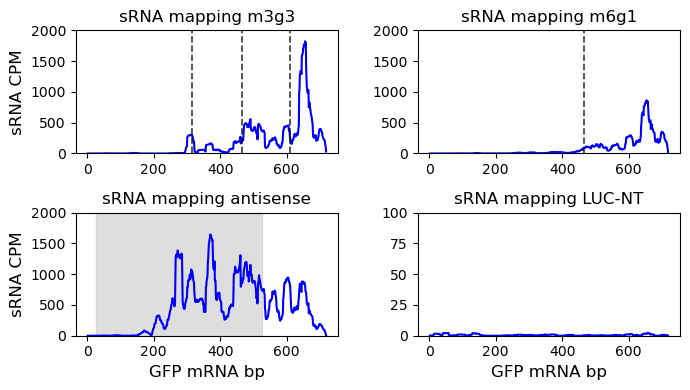

In [12]:
to_plot_ordered = ('eGFP.m3g3_9', 'Egfp m6g1-2.v2_9',
                   'eGFP.aseGFPv2_3', 'Luc-ET_2')

fig, ax = plt.subplots(2,2, figsize=(7,4), squeeze=True)
count = 0
for j in range(2):
    for i in range(2):
        current= to_plot_ordered[count]
        #lab = current #.split("_", 1)[-1]
        ax[j][i] = sns.lineplot(x="position", y=sRNA_map.loc[sRNA_map['sample'] == current, 'CPM'],
                               data=sRNA_map, ax=ax[j][i], color="blue")
        if 'm3g3' in current:
            ax[j][i].axvline(315, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].axvline(466, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].axvline(609, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].set(ylim=(0,2000))
            ax[j][i].set_title("sRNA mapping m3g3", size = 12)
            ax[j][i].set_xlabel("")
            ax[j][i].set_ylabel("sRNA CPM" ,size = 12)
        elif 'm6g1' in current:
            ax[j][i].axvline(466, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].set(ylim=(0,2000))
            ax[j][i].set_title("sRNA mapping m6g1", size = 12)
            ax[j][i].set_xlabel("")
            ax[j][i].set_ylabel(" ")
        #elif any([x in a_string for x in matches]):
        elif 'aseGFP' in current or 'asGFP' in current:
            ax[j][i].axvspan(26,525, color ='lightgrey', alpha = 0.75)
            ax[j][i].set(ylim=(0,2000))
            ax[j][i].set_title("sRNA mapping antisense", size = 12)
            ax[j][i].set_ylabel("sRNA CPM" ,size = 12)
            ax[j][i].set_xlabel("GFP mRNA bp" ,size = 12)
        else:
            ax[j][i].set(ylim=(0,100))
            ax[j][i].set_title("sRNA mapping LUC-NT", size = 12)
            ax[j][i].set_xlabel("GFP mRNA bp" ,size = 12)
            ax[j][i].set_ylabel(" ")
            pass 
        count += 1

fig.tight_layout()
plt.show()

### Figure 7e

In [14]:
sRNA_map.loc[sRNA_map['CPM'] > 20].groupby(['sample']).count()

,index,target,e_start,e_end,position,sRNA_count,library,lib_total,CPM
sample,,,,,,,,,
Egfp m6g1-2.v2_8,293,293,293,293,293,293,293,293,293
Egfp m6g1-2.v2_9,310,310,310,310,310,310,310,310,310
Egfp m6g1-2_10,295,295,295,295,295,295,295,295,295
eGFP.asGFP.v2_4,536,536,536,536,536,536,536,536,536
eGFP.aseGFP.v2_5,565,565,565,565,565,565,565,565,565
eGFP.aseGFPv2_3,560,560,560,560,560,560,560,560,560
eGFP.m3g3.v2_6,265,265,265,265,265,265,265,265,265
eGFP.m3g3_8,380,380,380,380,380,380,380,380,380
eGFP.m3g3_9,409,409,409,409,409,409,409,409,409


In [15]:
g20_CPM = sRNA_map.loc[sRNA_map['CPM'] > 20].groupby(['sample']).count()
g20_all = g20_CPM[['position', 'CPM']]
g20_all = g20_all.reset_index()
g20_all.loc[len(g20_all.index)] = ['Luc-ET_2', 0, 0]
g20_all.loc[len(g20_all.index)] = ['Luc-ET_3', 0, 0]
g20_all['trt'] = ['m6g1','m6g1','m6g1', 'asGFP', 'asGFP', 'asGFP', 
                  'm3g3','m3g3','m3g3', 'Luc-ET','Luc-ET']

g20_all = g20_all.sort_values('trt')

Text(0.5, 0, '')

[Text(0, 0, 'Luc-ET'),
 Text(1, 0, 'asGFP'),
 Text(2, 0, 'm3g3'),
 Text(3, 0, 'm6g1')]

Text(0, 0.5, 'Number of bp with CPM >20')

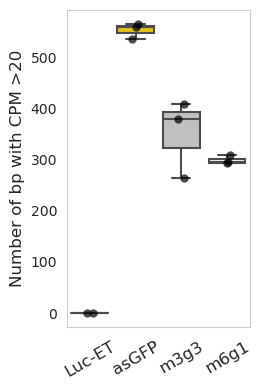

In [19]:
fig, ax= plt.subplots(figsize=(2.7,4), squeeze=True)
sns.set_style("whitegrid", {'axes.grid': False})

pal = ['b', 'gold', 'silver', 'whitesmoke']
p2= sns.boxplot(data=g20_all, x='trt', y='CPM', palette=pal)

# add the individual points of data, exclude the eGFP data point
p2= sns.stripplot(data=g20_all, x='trt', y='CPM', 
              size=6, color="black", linewidth=0, alpha=0.7)
p2.set_xlabel("")
p2.set_xticklabels(ax.get_xticklabels(), rotation=30, size=12)
p2.set_ylabel("Number of bp with CPM >20", size=12)

plt.rcParams['xtick.major.pad'] = 5

fig.tight_layout()

### Figure S4

<function seaborn.rcmod.reset_orig()>

[(0.0, 2000.0)]

Text(0.5, 1.0, 'eGFP.m3g3_8')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'eGFP.m3g3_9')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'eGFP.m3g3.v2_6')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'Egfp m6g1-2_10')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'Egfp m6g1-2.v2_9')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2000.0)]

Text(0.5, 1.0, 'Egfp m6g1-2.v2_8')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2500.0)]

Text(0.5, 1.0, 'eGFP.aseGFPv2_3')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2500.0)]

Text(0.5, 1.0, 'eGFP.asGFP.v2_4')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 2500.0)]

Text(0.5, 1.0, 'eGFP.aseGFP.v2_5')

Text(0.5, 0, ' ')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 100.0)]

Text(0.5, 1.0, 'Luc-ET_2')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

[(0.0, 100.0)]

Text(0.5, 1.0, 'Luc-ET_3')

Text(0, 0.5, 'smRNA CPM')

Text(0.5, 0, 'GFP mRNA bp')

(0.0, 1.0, 0.0, 1.0)

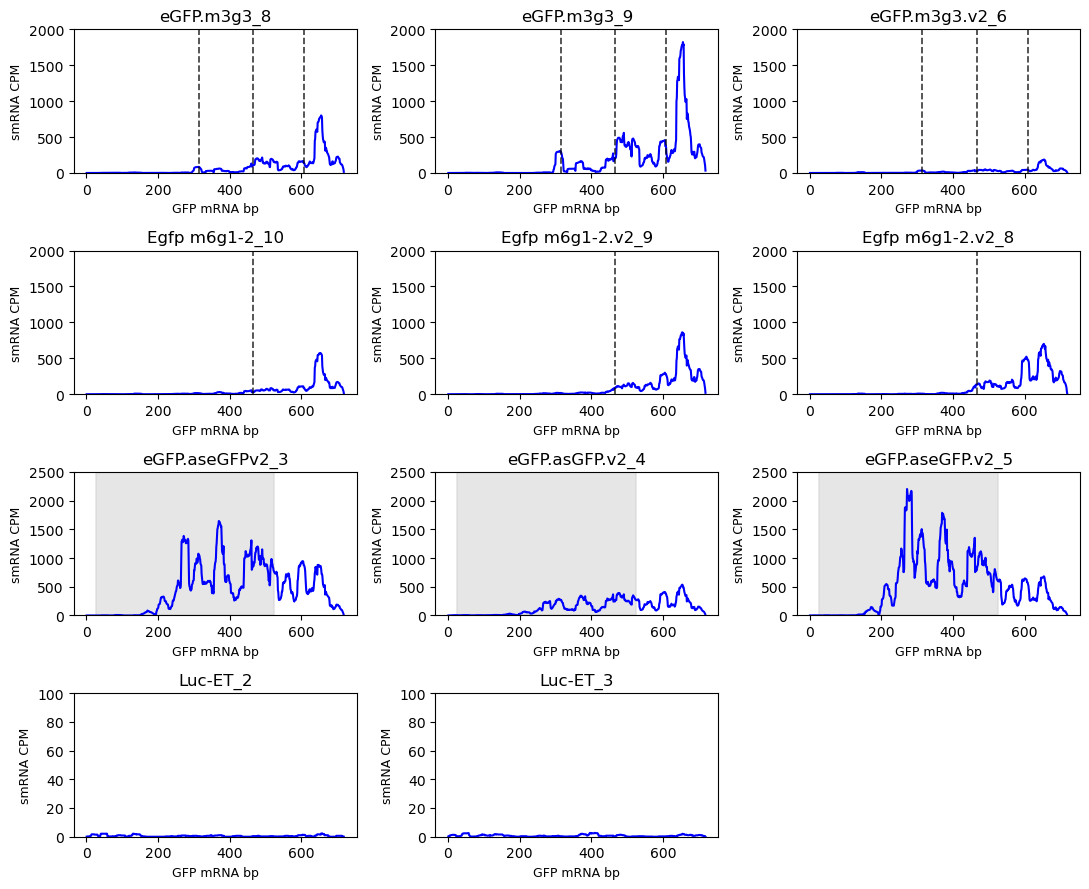

In [9]:
sns.reset_orig
to_plot_ordered = ('eGFP.m3g3_8', 'eGFP.m3g3_9', 'eGFP.m3g3.v2_6',
                   'Egfp m6g1-2_10','Egfp m6g1-2.v2_9', 'Egfp m6g1-2.v2_8',
                   'eGFP.aseGFPv2_3', 'eGFP.asGFP.v2_4','eGFP.aseGFP.v2_5',
                   'Luc-ET_2', 'Luc-ET_3')

fig, ax = plt.subplots(4,3, figsize=(11,9), squeeze=False)
count = 0
for j in range(4):
    for i in range(3):
        if j == 3:
            if i > 1:
                break
        current= to_plot_ordered[count]
        #lab = current #.split("_", 1)[-1]
        ax[j][i] = sns.lineplot(x="position", y=sRNA_map.loc[sRNA_map['sample'] == current, 'CPM'],
                               data=sRNA_map, ax=ax[j][i], color="blue")
        if 'm3g3' in current:
            ax[j][i].axvline(315, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].axvline(466, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].axvline(609, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].set(ylim=(0,2000))
            ax[j][i].set_title(current)
            ax[j][i].set_xlabel(" ")
        elif 'm6g1' in current:
            ax[j][i].axvline(466, color ='black', lw = 1.25, alpha = 0.75, linestyle='--')
            ax[j][i].set(ylim=(0,2000))
            ax[j][i].set_title(current)
            ax[j][i].set_xlabel(" ")
        #elif any([x in a_string for x in matches]):
        elif 'aseGFP' in current or 'asGFP' in current:
            ax[j][i].axvspan(26,525, color ='lightgrey', lw = 1.25, alpha = 0.55)
            ax[j][i].set(ylim=(0,2500))
            ax[j][i].set_title(current)
            ax[j][i].set_xlabel(" ")
        else:
            ax[j][i].set(ylim=(0,100))
            ax[j][i].set_title(current)
            pass 

        ax[j][i].set_ylabel("smRNA CPM" ,size = 9)
        ax[j][i].set_xlabel("GFP mRNA bp" ,size = 9)
        #ax[j][i].set(ylim=(0,2000))
        count += 1

ax[3, 2].axis('off')
fig.tight_layout()